## Loading Libraries

In [2]:
library('ggplot2')
library('gridExtra')
library(reshape2)
library(RColorBrewer)
library(grid)

## Set working directory and output directories

In [3]:
projectdir="../"
setwd(projectdir)
paperfigdir="figures"
supfigdir="figures/supfigures"

## Plotting Functions

In [4]:
add_corner_label <- function(p, letter){
    newp <- arrangeGrob(p, top=textGrob(toupper(letter), x=unit(0, "npc"), y=unit(1, "npc"), just=c("left", "top")))
    return(newp)
}

make_into_stars<-function(x){
    s=""
    if (x <= 0.05){s="*"}
    if (x <= 0.01){s="**"}
    if (x <= 0.001){s="***"}
    if (x <= 0.0001){s="****"}
    return(s)
}

In [39]:
get_cutoffs_from_perc <- function(y, svcf){
    num= round(length(y[y>0])*svcf)
    cf = sort(y, decreasing=TRUE)[num]
    return(cf)
}

make_tissue_type_boxdata2 <- function(pdat, pcf, types, cntdat, nulli){
    nullcnt = cntdat[,nulli]
    dfnull = data.frame(dat=pdat[nullcnt>0], label="SV detected")
    dfbox = dfnull
    wctests = c(1)
    cutoffs=c(1)
    for (mylabel in types) {
        rcnts <- cntdat[,which(names(cntdat)==mylabel)]
        cf = get_cutoffs_from_perc(rcnts[nullcnt > 0], pcf)
        cutoffs=c(cutoffs, cf)
        mydf = data.frame(dat = pdat[rcnts >= cf], label=mylabel)
        mydfn = data.frame(dat = pdat[rcnts < cf & nullcnt>0], label=paste0(mylabel, "_null"))
        dfbox = data.frame(rbind(dfbox, mydf))
        wctests = c(wctests, wilcox.test(mydf$dat, mydfn$dat, alternative="greater")$p.value)
    }
    return(list(dfbox, wctests, cutoffs))
}

make_tissue_type_violinplots <- function(dfbox, myks, mycfs, mycols=c("grey", brewer.pal(8,"Paired")), xl=10){
    mylabs=rle(as.character(dfbox$label))$values
    newlabs=c()
    for (i in seq_along(mylabs)){
        pn <- prettyNum(sum(dfbox$label== mylabs[i]), big.mark=",", scientific=TRUE)
        newl = paste0(mylabs[i], ", ", mycfs[i], "\n(", pn, ")")
        #newl = bquote(.(paste0(mylabs[i], "\n")) ( .(pn) >= .(mycfs[i]) ))
        newlabs=c(newlabs, newl)
    }
    pbox <- ggplot(dfbox, aes(x=label, y=dat)) + geom_violin() + 
    geom_boxplot(colour=mycols, fill=mycols, alpha=0.5, outlier.colour=NULL, width=0.2) + 
    labs(x="", y="Predicted DSB") + ylim(0,xl) + 
    scale_x_discrete(labels=newlabs) + 
    theme(axis.text.x = element_text(angle = 90, hjust=0.5, vjust=0.5, size=9), axis.title=element_text(size=10)) + 
    annotate("text", x=seq(1,(length(myks))), y=xl, label=unlist(lapply(myks, make_into_stars)), size=3)
    return(pbox)
}

# Figure 5

In [40]:
make_plot_panel <- function(mypcf, types, cntdat, nulli, myc){

    moddatn <- read.table("data/randforest_results/NHEK_BREAK/predicted.txt", header=TRUE)
    moddatk <- read.table("data/randforest_results/K562_BLISS/predicted.txt", header=TRUE)
    moddatm <- read.table("data/randforest_results/MCF7_BLISS/predicted.txt", header=TRUE)
    
    bd <- make_tissue_type_boxdata2(pdat=moddatn$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
    pboxn <- make_tissue_type_violinplots(bd[[1]], bd[[2]], bd[[3]], mycols=myc, xl=7) + ggtitle("NHEK")
    
    bd <- make_tissue_type_boxdata2(pdat=moddatk$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
    pboxk <- make_tissue_type_violinplots(bd[[1]], bd[[2]], bd[[3]], mycols=myc, xl=0.002) + ggtitle("K562")
    
    bd <- make_tissue_type_boxdata2(pdat=moddatm$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
    pboxm <- make_tissue_type_violinplots(bd[[1]], bd[[2]], bd[[3]], mycols=myc, xl=0.03) + ggtitle("MCF7")
    
    return(list(pboxn, pboxk, pboxm))
}

## Panels a-c, SV counts by tissue type

In [41]:
pcdat <- read.table("data/cancer_SVcnts/icgc/panc_realcnts.txt", header=TRUE)
brdat <- read.table("data/cancer_SVcnts/icgc/brca_realcnts.txt", header=TRUE)
bldat <- read.table("data/cancer_SVcnts/icgc/blood_realcnts.txt", header=TRUE)
cadat <- read.table("data/cancer_SVcnts/icgc/carc_realcnts.txt", header=TRUE)
dat <- data.frame(pancancer= pcdat$any, breast=brdat$any, 
    blood= bldat$any, carcinoma=cadat$any-brdat$any)
mynull=1
mytypes=c("pancancer", "carcinoma", "blood", "breast")
mycolors = c("grey", brewer.pal(10, "Paired")[c(2,4,6,8)])

In [42]:
gt <- make_plot_panel(mypcf=0.05, types=mytypes, cntdat=dat, nulli=mynull, myc=mycolors)

## Panels d-f, SV counts by SV type

In [43]:
dat <- read.table("data/cancer_SVcnts/icgc/panc_realcnts.txt", header=TRUE)
mynull=5
mytypes=c("any", "deletion", "duplication", "inversion", "interchr", "intrachr", "insertion", "translocation")
mycolors = c("grey", "grey33", brewer.pal(7, "Set1"))
gb <- make_plot_panel(mypcf=0.05, types=mytypes, cntdat=dat, nulli=mynull, myc=mycolors)

## putting all plots together 

In [44]:
mygrobs=list(gt[[1]], gt[[2]], gt[[3]])
length(mygrobs)
for (i in seq_along(mygrobs)){
    mygrobs[[i]] <- add_corner_label(mygrobs[[i]], letters[i])}

gt <- arrangeGrob(grobs=mygrobs, ncol=3)

mygrobs=list(gb[[1]], gb[[2]], gb[[3]])
length(mygrobs)
for (i in seq_along(mygrobs)){
    mygrobs[[i]] <- add_corner_label(mygrobs[[i]], letters[i+3])}

gb <- arrangeGrob(grobs=mygrobs, ncol=3)

[1] 3

Warning message:
“Removed 51 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 51 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 179 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 179 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 620 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 620 rows containing non-finite values (stat_boxplot).”

[1] 3

Warning message:
“Removed 74 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 74 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 194 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 194 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 799 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 799 rows containing non-finite values (stat_boxplot).”

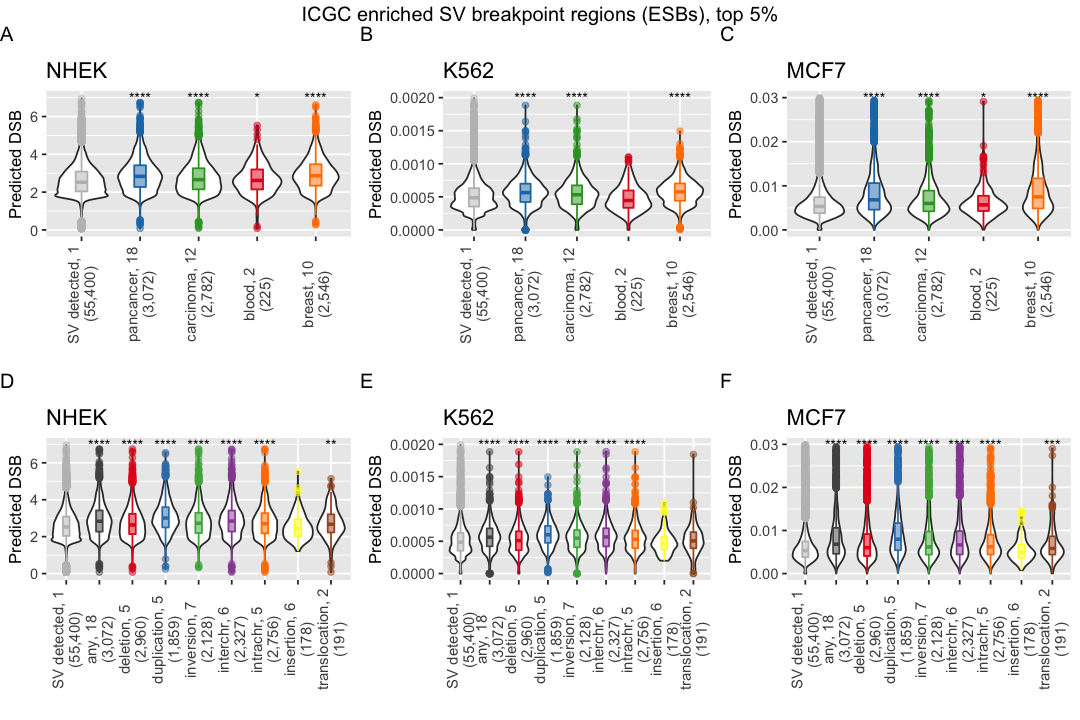

In [45]:
gf <- arrangeGrob(gt, gb, nrow=2, top="ICGC enriched SV breakpoint regions (ESBs), top 5%" )
options(repr.plot.width=9, repr.plot.height=6)
grid.arrange(gf)

In [46]:
ggsave(file="Figure5.png", plot=gf, path=paperfigdir, width=9, height=6, units="in", dpi=600)
ggsave(file="Figure5.pdf", plot=gf, path=paperfigdir, width=9, height=6, units="in", dpi=600)

# Figure S10
TCGA data by tissue type

In [47]:
dat <- read.table("data/cancer_SVcnts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
names(dat) <- sub("TCGA.", "", names(dat))
names(dat) <- sub(".all", "", names(dat))

mynull=15
mytypes=c("PANC", "SCCA", "BLOOD", "BRCA")
mycolors = c("grey", brewer.pal(8, "Paired")[c(2,4,6,8)])

g2 <- make_plot_panel(mypcf=0.05, types=mytypes, cntdat=dat, nulli=mynull, myc=mycolors)

In [48]:
## putting all plots together 
mygrobs=list(g2[[1]], g2[[2]], g2[[3]])
length(mygrobs)
for (i in seq_along(mygrobs)){
    mygrobs[[i]] <- add_corner_label(mygrobs[[i]], letters[i])}

gf <- arrangeGrob(grobs=mygrobs, ncol=3, top="TCGA enriched SV regions (ESBs), top 5%")
ggsave(file="SupFigure10_violin_TCGA_ESBs.pdf", plot=gf, path=supfigdir, width=8, height=3, units="in", dpi=600)
ggsave(file="SupFigure10_violin_TCGA_ESBs.png", plot=gf, path=supfigdir, width=8, height=3, units="in", dpi=600)

[1] 3

Warning message:
“Removed 20 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 20 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 184 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 184 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 260 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 260 rows containing non-finite values (stat_boxplot).”

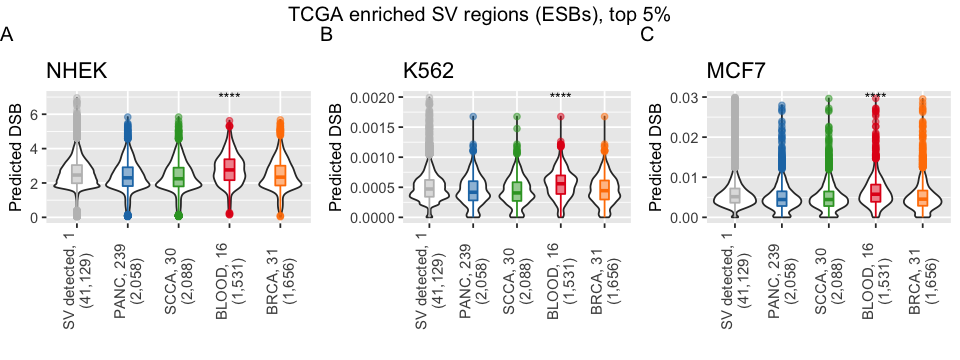

In [49]:
options(repr.plot.width=8, repr.plot.height=3)
grid.arrange(gf)

Note- at the p=0.01 level, none are significant